<a href="https://colab.research.google.com/github/vaibhaviapshinge10-oss/trader-sentiment-analysis/blob/main/trader_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part A**
1. Data Loading

In [ ]:
from google.colab import files
uploaded= files.upload()

Saving historical_data.csv to historical_data (2).csv
Saving fear_greed_index.csv to fear_greed_index (2).csv



2. **INITIAL DATA INSPECTION**
- Checking dataset size, preview, missing values


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

In [ ]:
sentiment= pd.read_csv('fear_greed_index.csv')
trades= pd.read_csv('historical_data.csv')
print('Sentiment shape:', sentiment.shape)
print('Trades shape:', trades.shape)
print("Preview of Sentiment Dataset:")
display(sentiment.head())
print("Preview of Trades Dataset:")
display(trades.head())

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)
Preview of Sentiment Dataset:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Preview of Trades Dataset:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [ ]:

# check for missing values
print('Missnig values in sentiment DataFrame:')
display(sentiment.isnull().sum())
print('Missing values in traders DataFrame:')
display(sentiment.isnull().sum())

Missnig values in sentiment DataFrame:


,0
timestamp,0
value,0
classification,0
date,0


Missing values in traders DataFrame:


,0
timestamp,0
value,0
classification,0
date,0


3. DATA CLEANING
 - Removing duplicates
 - Converting date columns
 - Preparing daily date format

In [ ]:
# handling duplicates if any
sentiment= sentiment.drop_duplicates()
trades= trades.drop_duplicates()

# convert date columns to datetime format
sentiment['date']= pd.to_datetime(sentiment['date'])

# Convert timestamp to datetime (DD-MM-YYYY HH:MM format)
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    format='%d-%m-%Y %H:%M'
)

# Extract only date for daily analysis
trades['date'] = trades['Timestamp IST'].dt.date
trades['date'] = pd.to_datetime(trades['date'])


4. FEATURE ENGINEERING:
 Creating trader-level daily metrics:
 - Daily PnL
 - Win rate
 - Trade frequency
 - Average trade size

In [ ]:

# Calculate total daily PnL per trader
daily_pnl = trades.groupby(['Account', 'date'])['Closed PnL'].sum().reset_index()

# Create win column (True if trade was profitable)
trades['win'] = trades['Closed PnL'] > 0

# calculate daily total pnl per trader
daily_pnl = trades.groupby(['Account', 'date'])['Closed PnL'].sum().reset_index()

 # create win column (1 if profit, 0 if loss)
trades['win'] = trades['Closed PnL'] > 0

 # calculate daily win rate
daily_winrate = trades.groupby(['Account', 'date'])['win'].mean().reset_index()

# count how many trades each account makes per day
daily_trades = trades.groupby(['Account', 'date']).size().reset_index(name='num_trades')

# average trade size in usd per day
daily_size = trades.groupby(['Account', 'date'])['Size USD'].mean().reset_index()


5. DATA MERGING
- Merging trader daily metrics with sentiment data
- Key used: date

In [ ]:
# merge all daily metrics together
trader_daily = (
    daily_pnl
        .merge(daily_winrate, on=['Account', 'date'])
        .merge(daily_trades, on=['Account', 'date'])
        .merge(daily_size, on=['Account', 'date'])
)

# now merge with sentiment data
final_df = trader_daily.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

# quick look at final dataset
final_df.head()


,Account,date,Closed PnL,win,num_trades,Size USD,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.000000,177,5089.718249,Extreme Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,0.000000,68,7976.664412,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,0.000000,40,23734.500000,Extreme Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,0.000000,12,28186.666667,Extreme Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,0.444444,27,17248.148148,Extreme Greed


 PART B:

 6. **Analysis**

Average PnL:
classification
Extreme Fear     4619.439053
Extreme Greed    5161.922644
Fear             5328.818161
Greed            3318.100730
Neutral          3438.618818
Name: Closed PnL, dtype: float64

Median PnL:
classification
Extreme Fear     218.377399
Extreme Greed    418.319862
Fear             107.892532
Greed            158.214922
Neutral          167.551743
Name: Closed PnL, dtype: float64

Win Rate:
classification
Extreme Fear     0.600000
Extreme Greed    0.682510
Fear             0.604762
Greed            0.611111
Neutral          0.622340
Name: win, dtype: float64

PnL Volatility (Std Dev):
classification
Extreme Fear     29534.839183
Extreme Greed    27496.863832
Fear             31659.771538
Greed            30599.040173
Neutral          17447.863645
Name: Closed PnL, dtype: float64

Average Trades Per Day:
classification
Extreme Fear     133.750000
Extreme Greed     76.030418
Fear              98.153968
Greed             77.628086
Neutral          100.228723
Name: 

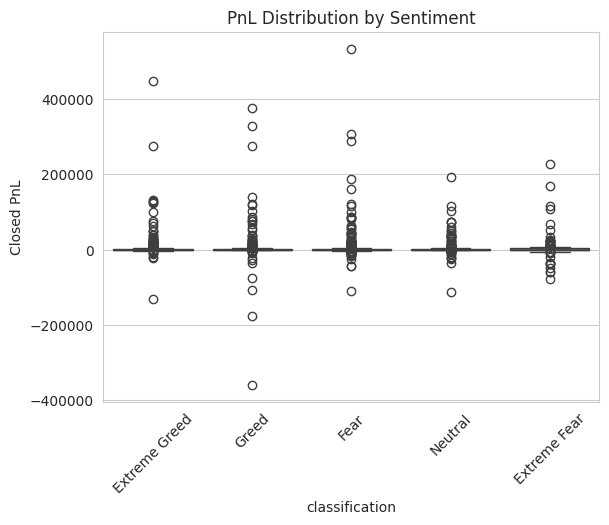

In [ ]:
# create win column (True if profit, False if loss)
final_df["win"] = final_df["Closed PnL"] > 0

# ---- PERFORMANCE COMPARISON----
# Comparing PnL, Win Rate, Volatility across sentiment regimes

# average pnl by sentiment
avg_pnl = final_df.groupby("classification")["Closed PnL"].mean()
print("Average PnL:")
print(avg_pnl)

# median pnl
median_pnl = final_df.groupby("classification")["Closed PnL"].median()
print("\nMedian PnL:")
print(median_pnl)

# win rate
win_rate = final_df.groupby("classification")["win"].mean()
print("\nWin Rate:")
print(win_rate)

# pnl standard deviation (used as volatility proxy)
pnl_std = final_df.groupby("classification")["Closed PnL"].std()
print("\nPnL Volatility (Std Dev):")
print(pnl_std)

#----  BEHAVIOR COMPARISON----
#  Comparing trade frequency and position sizing by sentiment

# average number of trades
avg_trades = final_df.groupby("classification")["num_trades"].mean()
print("\nAverage Trades Per Day:")
print(avg_trades)

# average trade size
avg_size = final_df.groupby("classification")["Size USD"].mean()
print("\nAverage Trade Size:")
print(avg_size)

#----  VISUALIZATION----
# Visual comparison of PnL distribution

sns.boxplot(x="classification", y="Closed PnL", data=final_df)
plt.title("PnL Distribution by Sentiment")
plt.xticks(rotation=45)
plt.show()



7. Visualization (Sentiment vs PnL)

Average Negative PnL (Drawdown Proxy):
classification
Extreme Fear    -15534.761937
Extreme Greed    -6109.737110
Fear             -6071.371829
Greed           -16562.519710
Neutral          -6879.440610
Name: Closed PnL, dtype: float64


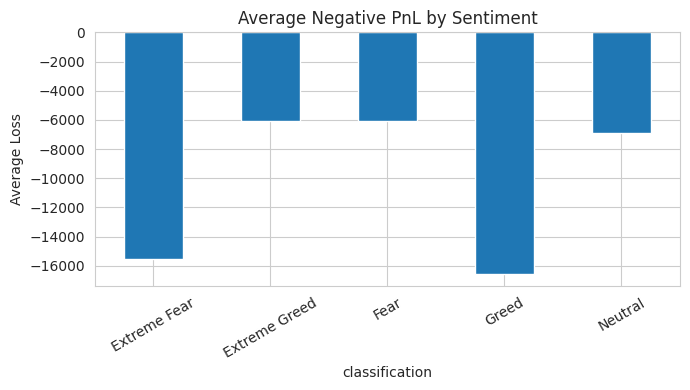

Average PnL by Frequency Segment:
segment
Frequent      5939.703473
Infrequent    3179.269742
Name: Closed PnL, dtype: float64


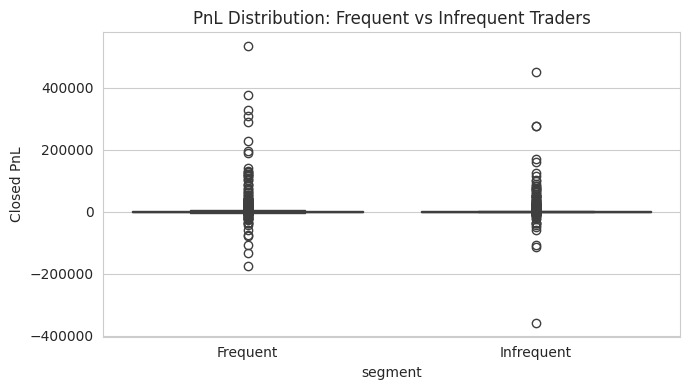

Average PnL by Consistency Segment:
consistency_segment
Consistent      4198.030710
Inconsistent    4743.174788
Name: Closed PnL, dtype: float64


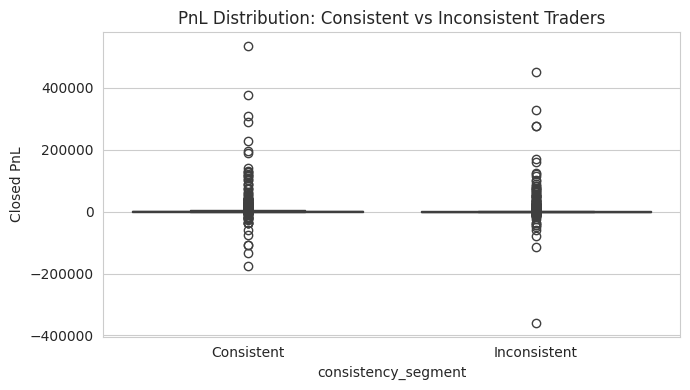

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (7,4)

# ==========================================================
# DRAWDOWN PROXY (Downside Risk by Sentiment)

drawdown_proxy = (
    final_df[final_df["Closed PnL"] < 0]
    .groupby("classification")["Closed PnL"]
    .mean()
)

print("Average Negative PnL (Drawdown Proxy):")
print(drawdown_proxy)

drawdown_proxy.plot(kind="bar")
plt.title("Average Negative PnL by Sentiment")
plt.ylabel("Average Loss")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# ==========================================================
# SEGMENTATION 1: Frequent vs Infrequent Traders

trader_freq = final_df.groupby("Account")["num_trades"].mean().reset_index()
median_trades = trader_freq["num_trades"].median()

trader_freq["segment"] = np.where(
    trader_freq["num_trades"] > median_trades,
    "Frequent",
    "Infrequent"
)

segmented_df = final_df.merge(trader_freq[["Account", "segment"]], on="Account")

segment_performance = segmented_df.groupby("segment")["Closed PnL"].mean()

print("Average PnL by Frequency Segment:")
print(segment_performance)

sns.boxplot(x="segment", y="Closed PnL", data=segmented_df)
plt.title("PnL Distribution: Frequent vs Infrequent Traders")
plt.tight_layout()
plt.show()


# ==========================================================
# SEGMENTATION 2: Consistent vs Inconsistent Traders

trader_consistency = final_df.groupby("Account")["win"].mean().reset_index()
median_win = trader_consistency["win"].median()

trader_consistency["consistency_segment"] = np.where(
    trader_consistency["win"] > median_win,
    "Consistent",
    "Inconsistent"
)

segmented_df2 = final_df.merge(
    trader_consistency[["Account", "consistency_segment"]],
    on="Account"
)

consistency_perf = segmented_df2.groupby("consistency_segment")["Closed PnL"].mean()

print("Average PnL by Consistency Segment:")
print(consistency_perf)

sns.boxplot(x="consistency_segment", y="Closed PnL", data=segmented_df2)
plt.title("PnL Distribution: Consistent vs Inconsistent Traders")
plt.tight_layout()
plt.show()


# Part B – Analysis
***1. Performance: Fear vs Greed***

1. Average PnL is higher during Fear
(5,328) than Greed (3,318).

2. PnL volatility is highest during Fear (31,659 std dev).

3. Win rate is slightly higher during Greed (61.1%) than Fear (60.5%).

4. Average negative PnL (drawdown proxy) is larger during Fear regimes, indicating deeper losses during adverse trades.

***Conclusion:*** Fear regimes generate higher returns but with higher risk.

***2. Behavioral Changes***

1. Trade frequency is highest during Extreme Fear (134 trades/day).

2. Average trade size is highest during Fear (8,976 USD).

3. Traders become more aggressive (larger size + more trades) during Fear regimes.

***3. Trader Segments***

1. Frequent traders generally generate higher average PnL, but their results are more volatile.

2. Consistent traders (higher win rate accounts) perform more steadily across different sentiment regimes.

3. Performance gaps become wider during Fear periods, meaning disciplined traders handle volatility better than inconsistent ones

**Part C – Actionable Strategies**

***Strategy 1:***

During Fear and Extreme Fear periods, reduce position size and overall exposure, especially for traders with inconsistent performance.

***Strategy 2:***

Increase trading activity during Fear regimes only for traders with strong historical win rates. Others should trade less and focus on risk control.

**Bonus**

         num_trades      Size USD       win    Closed PnL
cluster                                                  
0        207.845811   8020.219907  0.761760   6371.383325
1         49.961675   8017.942501  0.440979   4499.575768
2        159.083333  33569.102224  0.666667  66676.242499


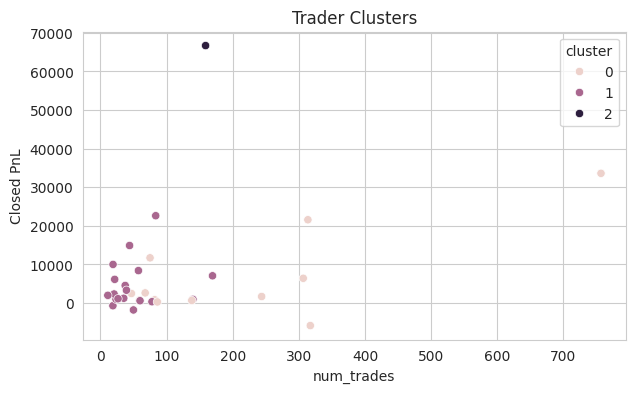

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Aggregate trader-level features
trader_features = final_df.groupby("Account").agg({
    "num_trades": "mean",
    "Size USD": "mean",
    "win": "mean",
    "Closed PnL": "mean"
}).reset_index()

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(
    trader_features[["num_trades", "Size USD", "win", "Closed PnL"]]
)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
trader_features["cluster"] = kmeans.fit_predict(scaled_features)

# View cluster summary
cluster_summary = trader_features.groupby("cluster")[
    ["num_trades", "Size USD", "win", "Closed PnL"]
].mean()

print(cluster_summary)

sns.scatterplot(
    data=trader_features,
    x="num_trades",
    y="Closed PnL",
    hue="cluster"
)
plt.title("Trader Clusters")
plt.show()
